# A Tutorial on Model Ensembles: Maximum Margin Output Coding (MMOC)

Author: **Emilio Esposito ([LinkedIn](https://www.linkedin.com/in/emilioespositousa) | [Portfolio](https://eesposito.com/) | [GitHub](https://github.com/EmilioEsposito))**

## Table of Contents
* [Introduction](#introduction)<br/>
* [Data Prep](#Data Prep)<br/>
* [Binarize the target](#Binarize the target)<br/>
* [Create N Binary Classifiers](#Create N Binary Classifiers)<br/>
* [Plotting Individual ROC curves](#Plotting Individual ROC curves)<br/>
* [Picking the winning class: Applying MMOC](#Picking the winning class: Applying MMOC)<br/>
* [Measuring Multiclassification Error: Confusion Matrix](#Measuring Multiclassification Error: Confusion Matrix)<br/>
* [Measuring Multiclassification Error: Accuracy, TPR, and FPR](#Measuring Multiclassification Error: Accuracy, TPR, and FPR)<br/>
* [Conclusion](#Conclusion)<br/>



<a id='introduction'></a>
## Introduction

The objective of this tutorial is to introduce the concept of model ensembles, and show one specific type of model ensemble in detail. The type of model ensemble we will cover is called Maximum Margin Output Coding (MMOC). 

So what exactly is a model ensemble? **A model ensemble is the process of using more than one model instead of a single model for prediction; the outputs of several models are combined together using a specified voting scheme to achieve a single prediction for each record.** 

MMOC is an approach that is used for multi-classification (i.e. binary classification is just between two classes A and B, but multi-classification can handle N number of classes A,B,C,D, etc). It does this by using N number of binary classifiers, and then combining their results into a single prediction for each record.

MMOC is similar to Error Correcting Output Coding (ECOC), but is simpler because it takes advantage of the probabilistic real-valued output values from margin-based classifiers (in other words, it uses the probability output number between 0.0 and 1.0 ). ECOC requires individual cutoff values to be chosen before the outputs can be combined, but MMOC simply uses the probabilistic output as a proxy for "confidence". The simplest version of MMOC simply chooses the final class by selecting the model with the highest confidence score (highest probability of being in the class). An extremely simple example is shown below, but we'll also implement this in practice later:

<img src="http://esporealestate.com/MMOC.png"></img>

For a detailed research paper on MMOC, refer to this publication: 
* [Yi Zhang & Jeff Schneider. Carnegie Mellon University. Maximum Margin Output Coding, ICML 2012.](http://www.cs.cmu.edu/~yizhang1/docs/MaxMarginCoding.pdf)

And for a easier to understand slide-deck on margin based encoding:
* [Erin Allwein, Rob Schapire, & Yoram Singer. Princeton University. Reducing Multiclass to Binary: A Unifying Approach for Margin Classifiers](http://www.cs.princeton.edu/~schapire/talks/ecoc-icml10.pdf)

There are other equally valid approaches to tackle multi-classification besides MMOC that do not even use an ensemble (such as a Bayes Net or Softmax Regression), but there are some scenarios where it makes more sense to use an ensemble of several models rather than a single model. For example, if the different classes are driven by different and muttually exclusive features, then an ensemble would be more appropriate. Here is classic example where MMOC would be preferred over a single multinomial classfier:
* class A is best predicted by features x1 and x2, but is completely independent of other features
* class B is best predicted by features x3 and x4, but is completely independent of other features
* class C is best predicted by features x5 and x6, but is completely independent of other features

Also, MMOC ensembling allows the individual N binary classifers to use different features and even different models. Class "A" might use logistic regression, but class "B" might use Support Vector Machines (just to illustrate, this scenario would actually be unusual).


Now let's get to our example!

<a id='Data Prep'></a>
## Data Prep

In [1]:
# import necessary libaries 
from sklearn import datasets
from sklearn import metrics
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn import svm
from matplotlib import colors
%matplotlib inline  


For this exercise, we are going to use the standard Iris dataset found in the scikit-learn library.

In [2]:
iris_dict = datasets.load_iris()
print iris_dict.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']


The Iris data has has 3 possible target classes:

In [3]:
target_names = list(iris_dict['target_names'])
feature_names = iris_dict['feature_names']
print target_names
print feature_names

['setosa', 'versicolor', 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [4]:
# put the X variables into a dataframe
irisX = pd.DataFrame(iris_dict['data'], columns=iris_dict['feature_names'])

# let's make a copy so we can add the target variable
iris = irisX.copy()

# add the numeric target
iris['target'] = iris_dict['target']

# let's shuffle the rows so we get a more representative sample of targets when we preview the data using head()
np.random.seed(seed=4)
iris = iris.iloc[np.random.choice(len(iris), len(iris), replace=False, ),:]

# create mapping of numeric target to target actual name
tn_dict = {i:target_names[i] for i in range(len(target_names))}

# add target name as well
iris['target_name'] = iris['target'].map(tn_dict)

# preview final data
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
128,6.4,2.8,5.6,2.1,2,virginica
18,5.7,3.8,1.7,0.3,0,setosa
130,7.4,2.8,6.1,1.9,2,virginica
105,7.6,3.0,6.6,2.1,2,virginica
107,7.3,2.9,6.3,1.8,2,virginica


Now let's show some descriptive statistics for each column. Note the uniform distribution of the target. This uniform distribution will allow us to simplify our approach to MMOC later on:

In [5]:
# Prints descriptive stats on the data.
# For numerics, it prints mean, min, max, and standard deviation
# For categorical, it prints the count distribution
def desc_statistics(df):
    for col in df:
        x = df[col]

        # print name & datatype
        print col, "[datatype="+str(x.dtype)+"]"

        # handle categorical 
        if x.dtype=='object':
            print "\tCounts:"
            print "\t",str(x.value_counts()).replace("\n","\n\t")
        # handle numeric
        else:
            print "\tMean:",str(np.mean(x))
            print "\tMin:",str(np.min(x))
            print "\tMax:",str(np.max(x))
            print "\tStd Dev:",str(np.std(x))       

desc_statistics(iris)

sepal length (cm) [datatype=float64]
	Mean: 5.84333333333
	Min: 4.3
	Max: 7.9
	Std Dev: 0.825301291785
sepal width (cm) [datatype=float64]
	Mean: 3.054
	Min: 2.0
	Max: 4.4
	Std Dev: 0.432146580071
petal length (cm) [datatype=float64]
	Mean: 3.75866666667
	Min: 1.0
	Max: 6.9
	Std Dev: 1.75852918341
petal width (cm) [datatype=float64]
	Mean: 1.19866666667
	Min: 0.1
	Max: 2.5
	Std Dev: 0.760612618588
target [datatype=int32]
	Mean: 1.0
	Min: 0
	Max: 2
	Std Dev: 0.816496610641
target_name [datatype=object]
	Counts:
	virginica     50
	setosa        50
	versicolor    50
	Name: target_name, dtype: int64


<a id='Binarize the target'></a>
## Binarize the target
You may have thought we were ready to begin modeling, but remember since we have multiple classes (3 in this case), we need to create 3 binary variables to represent our targets. 

In [6]:
# binarize the target
dummies = pd.get_dummies(iris['target_name'])

# add/update binarized cols to df
for predcol in dummies.columns:
    iris[predcol] = dummies[predcol]
    
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name,setosa,versicolor,virginica
128,6.4,2.8,5.6,2.1,2,virginica,0.0,0.0,1.0
18,5.7,3.8,1.7,0.3,0,setosa,1.0,0.0,0.0
130,7.4,2.8,6.1,1.9,2,virginica,0.0,0.0,1.0
105,7.6,3.0,6.6,2.1,2,virginica,0.0,0.0,1.0
107,7.3,2.9,6.3,1.8,2,virginica,0.0,0.0,1.0


<a id='Create N Binary Classifiers'></a>
## Create N Binary Classifiers
Now it's time to build our binary models. Each model should be trained and cross-validated separately. We could use different sets of features for each class and even use different types of models. However, the purpose of this tutorial is not to teach feature selection, model selection, and cross-validation, so I won't explain the details here. I just want to show how to combine output from several models. For more background information on classification and cross-validation, please refer to [these lecture notes](http://www.datasciencecourse.org/nonlinear_modeling.pdf) from Carnegie Mellon University's [Practical Data Science](http://www.datasciencecourse.org/) course.


Now let's create our 3 binary classifiers using SVM models:


In [7]:
# loop through each target class
for target_name in target_names:
    
    # split data into X and y
    X = iris[feature_names]
    y = iris[target_name]
    
    k = len(X)
    kf = KFold(len(X), n_folds=k, shuffle=True, random_state=5)
    #loop through each fold
    for train_index, hold_index in kf:
        
        # split into train and hold
        trainx = X.iloc[train_index,:]
        trainy = y[train_index]
        holdx = X.iloc[hold_index,:]
        
        # build SVM 
        model = svm.SVC(probability=True, C=1,gamma=.05,random_state=5)    
    
        # fit the model using train and return probabilistic predictions of holdout
        fit = model.fit(trainx, trainy)
        prob = fit.predict_proba(holdx)
    
        # add the probabilist output to the original dataframe
        iris.loc[hold_index,'probclass_'+target_name] = prob[:,0]

As you see below, we added a probabilistic output for each classifer (the columns with the "probclass_" prefix

In [8]:
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name,setosa,versicolor,virginica,probclass_setosa,probclass_versicolor,probclass_virginica
128,6.4,2.8,5.6,2.1,2,virginica,0.0,0.0,1.0,0.635576,0.699851,0.826809
18,5.7,3.8,1.7,0.3,0,setosa,1.0,0.0,0.0,0.655379,0.642097,0.664245
130,7.4,2.8,6.1,1.9,2,virginica,0.0,0.0,1.0,0.658594,0.661425,0.655054
105,7.6,3.0,6.6,2.1,2,virginica,0.0,0.0,1.0,0.653835,0.650305,0.657817
107,7.3,2.9,6.3,1.8,2,virginica,0.0,0.0,1.0,0.653676,0.662541,0.642726


<a id='Plotting Individual ROC curves'></a>
## Plotting Individual ROC curves
Even though this is a multinomial classification problem, we still want to check the validity of the individual binary classifiers before we combine results. However, even if all of our binary classifiers have good AUCs, this tells us NOTHING about the error of our final output. In the next section we'll combine the binary classifiers and then measure the overall error using a confusion matrix. But for now, let's take a look at how our binary classifiers did:

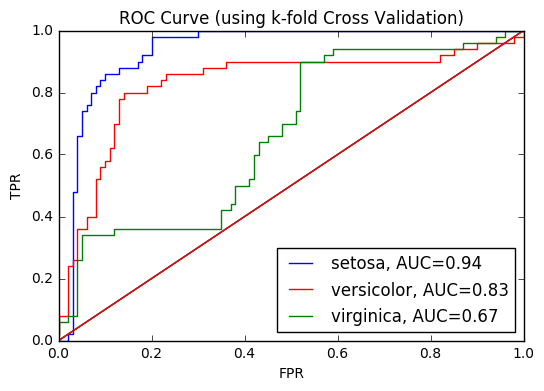

In [9]:
# take a dataframe and plot all of the binary classifier curves on a single figure
def plotROC(df,pred_col_prefix):

    df = df.copy()
    
    # get a list of the prediction columns
    predcols = [col for col in df.columns if col[:10]==pred_col_prefix]
    
    fig, ax = plt.subplots()
    
    mycolors = ['blue','red','green'] +list(colors.cnames)
    
    for i, (target_name, predcol) in enumerate(zip(target_names,predcols)):
        
        truth = df[target_name]
        pred = df[predcol]

        # calclulate fpr/tpr metrics
        fpr, tpr, _ = metrics.roc_curve(truth, pred)

        # calc the AUC
        auc = metrics.roc_auc_score(truth, pred)

        # set labels
        plt.ylabel("TPR")
        plt.xlabel("FPR")
        plt.title("ROC Curve (using k-fold Cross Validation)")

        # plot the default model line
        plt.plot([0,1])
        
        # plot tpr/fpr on ROC
        leg_label = target_name + ", AUC=" + str(round(auc, 2))
        ax.plot(fpr, tpr, color=mycolors[i], label=leg_label)

        # Begin citation for legend: http://matplotlib.org/1.3.0/examples/pylab_examples/legend_demo.html
        # Now add the legend with some customizations.
        legend = ax.legend(loc='lower right')
    plt.show()

plotROC(iris,"probclass_")

We'll discuss detailed interpretation of TPR and FPR later. For now, just recognize that a random choice model would produce the diagonal line. A perfect model (0 error) would be a line that goes straight up from (0,0) to (0,1), then takes a 90 degree turn right to (1,1). Any curve above the diagonal is doing better than random chance, and the closer it bulges towards (0,1) the better. AUC measures the area under the curve. AUC=1 indicates a perfect model, and AUC=0.50 indicates a random choice model (the diagonal line).

<a id='Picking the winning class: Applying MMOC'></a>
## Picking the winning class: Applying MMOC
Now that we validated our individual binary classifiers, it's time to combine their results into a single final prediction for each record. 

As we eluded to earlier, we will do this by using the simplest approach of MMOC: pick the classifier that has the highest confidence (in this case, we are simply using the real-valued probability as the confidence). This approach is only valid if the distribution of our classes is relatively uniform. If the distribution was not uniform, we would either need another measure of confidence taking the distribution into account, or we would need to apply cutoff values and employ ECOC instead.

In [10]:
# this function takes a dataframe, looks for columns that have probabilistic output (denoted by prefix probclass_)
# it then picks the winning classifier based on which one had the highest confidence
# it records the winner in both a pred_target_name column, and also in binarized predclass_ columns
def applyMMOC(df):
    df = df.copy()
    
    # get a list of the prediction columns
    predcols = [col for col in df.columns if col[:10]=='probclass_']
    
    # choose the winning classifier by picking the one with the highest probability/confidence
    df['pred_target_name'] = df[predcols].idxmax(axis=1)
    
    # trim the predicted target name
    df['pred_target_name'] = df['pred_target_name'].apply(lambda x: x.replace('probclass_',""))
    
    # get dummies of pred as well, we can use them later to easily calc error metrics
    pred_dummies = pd.get_dummies(df['pred_target_name'])
    pred_dummies.columns = ["predclass_"+str(col) for col in pred_dummies.columns]
    
    # add the dummies to the df
    for predcol in pred_dummies.columns:
        df[predcol]=pred_dummies[predcol]

    return df

# preview final data with predictions
iris = applyMMOC(iris)
iris.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name,setosa,versicolor,virginica,probclass_setosa,probclass_versicolor,probclass_virginica,pred_target_name,predclass_setosa,predclass_versicolor,predclass_virginica
128,6.4,2.8,5.6,2.1,2,virginica,0.0,0.0,1.0,0.635576,0.699851,0.826809,virginica,0.0,0.0,1.0
18,5.7,3.8,1.7,0.3,0,setosa,1.0,0.0,0.0,0.655379,0.642097,0.664245,virginica,0.0,0.0,1.0
130,7.4,2.8,6.1,1.9,2,virginica,0.0,0.0,1.0,0.658594,0.661425,0.655054,versicolor,0.0,1.0,0.0
105,7.6,3.0,6.6,2.1,2,virginica,0.0,0.0,1.0,0.653835,0.650305,0.657817,virginica,0.0,0.0,1.0
107,7.3,2.9,6.3,1.8,2,virginica,0.0,0.0,1.0,0.653676,0.662541,0.642726,versicolor,0.0,1.0,0.0


<a id='Measuring Multiclassification Error: Confusion Matrix'></a>
## Measuring Multiclassification Error: Confusion Matrix
Now that we have combined the output of our 3 binary models, we can now measure our error using a confusion matrix. 

In [11]:
# This funtion returns a nice df confusion matrix. Sklearn.metrics has it's own function but this is nicer.
def getConfusionMatrix(df, y_truth, y_pred):
    df = df.copy()
    
    labels = set(df[y_truth]).union(set(df[y_pred]))
    
    # create column of ones
    df['ones'] = np.ones(len(df))
    
    # create pivoted df that shows truth vs predicted value counts
    confmat = pd.pivot_table(df, values = 'ones', index=[y_truth], columns=[y_pred], aggfunc=np.sum, margins=True)
    
    return confmat

confmat = getConfusionMatrix(iris,'target_name','pred_target_name')
confmat

pred_target_name,setosa,versicolor,virginica,All
target_name,,,,
setosa,36.0,2.0,12.0,50.0
versicolor,4.0,44.0,2.0,50.0
virginica,2.0,21.0,27.0,50.0
All,42.0,67.0,41.0,150.0


The matrix rows contain the true label counts, and the columns show the predicted label counts. A perfect model would result in a diagonal matrix (non-zero counts along the diagonal, with zero everywhere else). 

<a id='Measuring Multiclassification Error: Accuracy, TPR, and FPR'></a>
## Measuring Multiclassification Error: Accuracy, TPR, and FPR


### Overall Accuracy 
You can think of overall accuracy as the sum of the values along the diagonal in the confusion matrix, divided by the total record count:

$$ Accuracy = \frac{\#\ correct\ predictions}{N} $$


In [12]:
accuracy = sk.metrics.accuracy_score(iris['target_name'],iris['pred_target_name'])
accuracy

0.71333333333333337

### True Positive Rate & False Positive Rate
Now we will calculate the True Positive Rate (TPR) and the False Postive Rate (FPR) for each class. If you look at the ROC curves earlier, you'll notice these are the 2 metrics on each axis. A TPR measures how many times a model correctly classifies a record as being part of a given class. A FPR measures how many times a model classifies a record as being a member of the given class, when in reality it is NOT a member of that class. A perfect model would have a TPR of 1.00 (100%) and a FPR of 0.00 (0%). In practice, there is usually a tradeoff between these 2 metrics. They can also be expressed as the equations below:

$$ TPR_{ClassA} = \frac{\#\ Records\ Model\ Classified\ Correctly\ as\ Class\ A}{\#\ of\ Class\ A\ Records} = \frac{\#\ True\ Positives}{\#\ Positives} $$

$$ FPR_{ClassA} = \frac{\#\ Records\ Model\ Classified\ INCORRECTLY\ as\ Class\ A}{\#\ of\ NOT\ Class\ A\ Records} = \frac{\#\ False\ Positives}{\#\ Negatives} $$

In [13]:
# given a confusion matrix df, return a df of the TPR and FPR of each class
def getTPRFPR(confusion_matrix_df):
    
    df = confusion_matrix_df.copy()
    
    # get target_names and remove "All"
    target_names = list(df.index)
    target_names.remove("All")
    
    # take a subset of the confusion matrix, removing "All" rows/cols
    df = df.loc[target_names,target_names]
    
    # create a dict to fill with other dictionaries of metrics for each label
    label_metrics = {}

    for label in target_names:
        # add sub dictionary for metric
        label_metrics[label] = {}

        label_metrics[label]["FPR"] = sum(df.loc[((df.index!=label) ),label])/(sum(sum(df.values)) - sum(df.loc[label,target_names]))
        label_metrics[label]["TPR"] = df.loc[label,label]/sum(df.loc[label,target_names])
        
    # make it into a nice dataframe for display
    tprfpr_df = pd.DataFrame(label_metrics).transpose()
    return tprfpr_df

getTPRFPR(confmat)

,FPR,TPR
setosa,0.06,0.72
versicolor,0.23,0.88
virginica,0.14,0.54


Not bad! Looks like our TPRs are relatively high yet our FPRs are relatively low.

<a id='Conclusion'></a>
## Conclusion
Although this Iris dataset is not necessarily the ideal usage of a model ensemble using MMOC, my objective was to convey the methodology as simply as possible. This model ensemble framework can be greatly extended with other several other important data science techniques that were purposely glossed over in this tutorial (visualization, feature selection, cross validation, etc). 

For additional background on other aspects of data science, a terrific resource is the website for [Carnegie Mellon University's 15-688 Practical Data Science Course](http://www.datasciencecourse.org/). Hope you enjoyed my tutorial!

Written by:

**Emilio Esposito ([LinkedIn](https://www.linkedin.com/in/emilioespositousa) | [Portfolio](https://eesposito.com/) | [GitHub](https://github.com/EmilioEsposito))**